In [18]:
import os
import json
import numpy as np
import xarray as xr
import geopandas as gpd

import cartopy.crs as ccrs

from multiprocessing import Pool

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import sys
sys.path.append(os.path.abspath(".."))
from function import ART_downscale as ART_down

In [2]:
# product, time_reso = 'IMERG', '1dy'
product, time_reso = 'IMERG', '3h'

# product, time_reso = 'MSWEP', '3h'
# product, time_reso = 'CMORPH', '3h'

yy_s, yy_e = 2002, 2012
years_num = yy_e - yy_s + 1
lon_min, lon_max, lat_min, lat_max = 10.5, 13.5, 44.5, 47

In [3]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite')

In [4]:
json_read = f'../json/{product}_{time_reso}.json'

if os.path.exists(json_read):
    with open (json_read) as f:
        param = json.load(f)
else:
    raise SystemExit(f"File not found: {json_read}")

print(f'Read json file   : {json_read.split('/')[-1]}')
print(f'Number of threads: {param['BETA_cores']}')

Read json file   : IMERG_3h.json
Number of threads: 22


In [5]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    VENETO = gpd.read_file(os.path.join(veneto_dir,'Veneto.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

## Load DATA

In [6]:
print(f'Reading Data File : {param['file']}') 
dir_data = os.path.join(dir_base,product,time_reso,param['file'])

PRE_data = xr.open_dataset(dir_data)
PRE_data = PRE_data.sel(time=PRE_data.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))

if product == 'MSWEP':
    PRE_data = PRE_data.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))
else:
    PRE_data = PRE_data.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

if time_reso == '3h':
    PRE_data = PRE_data.resample(time ='D').sum(dim='time', skipna=False)

lats = PRE_data['lat'].data
lons = PRE_data['lon'].data
lon2d, lat2d = np.meshgrid(lons, lats)

Reading Data File : IMERG_Italy_3h_2001_01_01_2023_12_31.nc


Text(0.0, 1.0, '(b) Daily maximum rainfall')

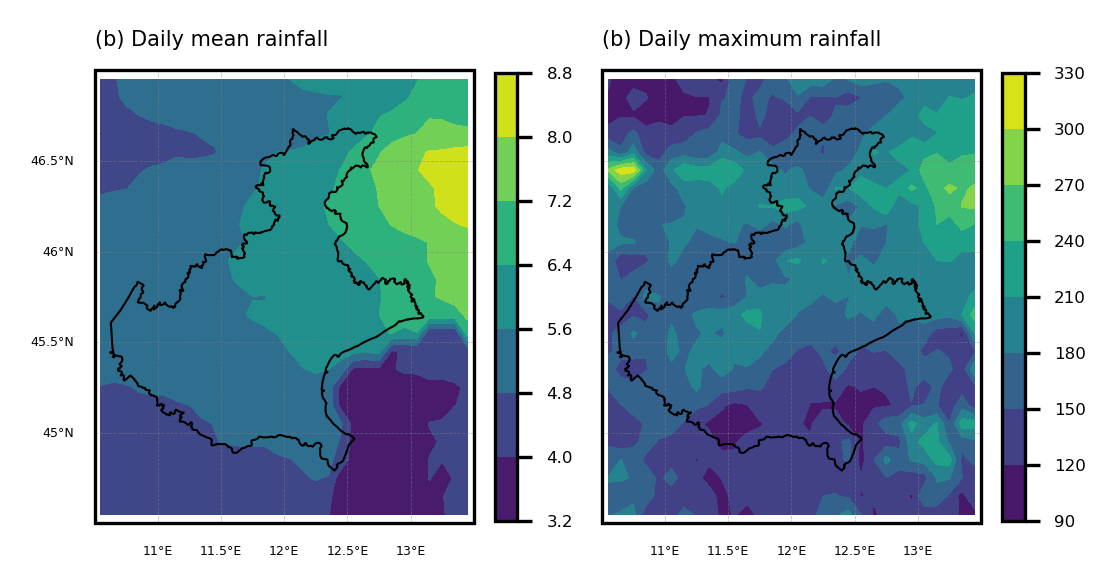

In [34]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(4,2),dpi=300)
gs = gridspec.GridSpec(1,2)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)

a1 = ax1.contourf(lon2d, lat2d, PRE_data['PRE'].mean(dim='time'))

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(b) Daily mean rainfall', fontsize=5, loc='left')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)

a1 = ax1.contourf(lon2d, lat2d, PRE_data['PRE'].max(dim='time'))

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(b) Daily maximum rainfall', fontsize=5, loc='left')

## Yearly Weibull Parameters

In [7]:
num_processes = max(1, os.cpu_count() - 2)

def process_point(args):
    i, j, PRE_data, lats, lons = args
    TMP = ART_down.weibull_year_parameters(PRE_data, lats[i], lons[j], 1, 50)
    return i, j, TMP

# Crear lista de argumentos
args = [(i, j, PRE_data, lats, lons) for i in range(len(lats)) for j in range(len(lons))]

# Paralelizar cálculos
with Pool(processes=num_processes) as pool:
    results = pool.map(process_point, args)

# Recolectar resultados
N = np.zeros([years_num, len(lats), len(lons)])
C = np.zeros([years_num, len(lats), len(lons)])
W = np.zeros([years_num, len(lats), len(lons)])

for i, j, TMP in results:
    N[:, i, j] = TMP[:, 0]
    C[:, i, j] = TMP[:, 1]
    W[:, i, j] = TMP[:, 2]

Text(0.0, 1.0, '(c) Mean of Shape parameter')

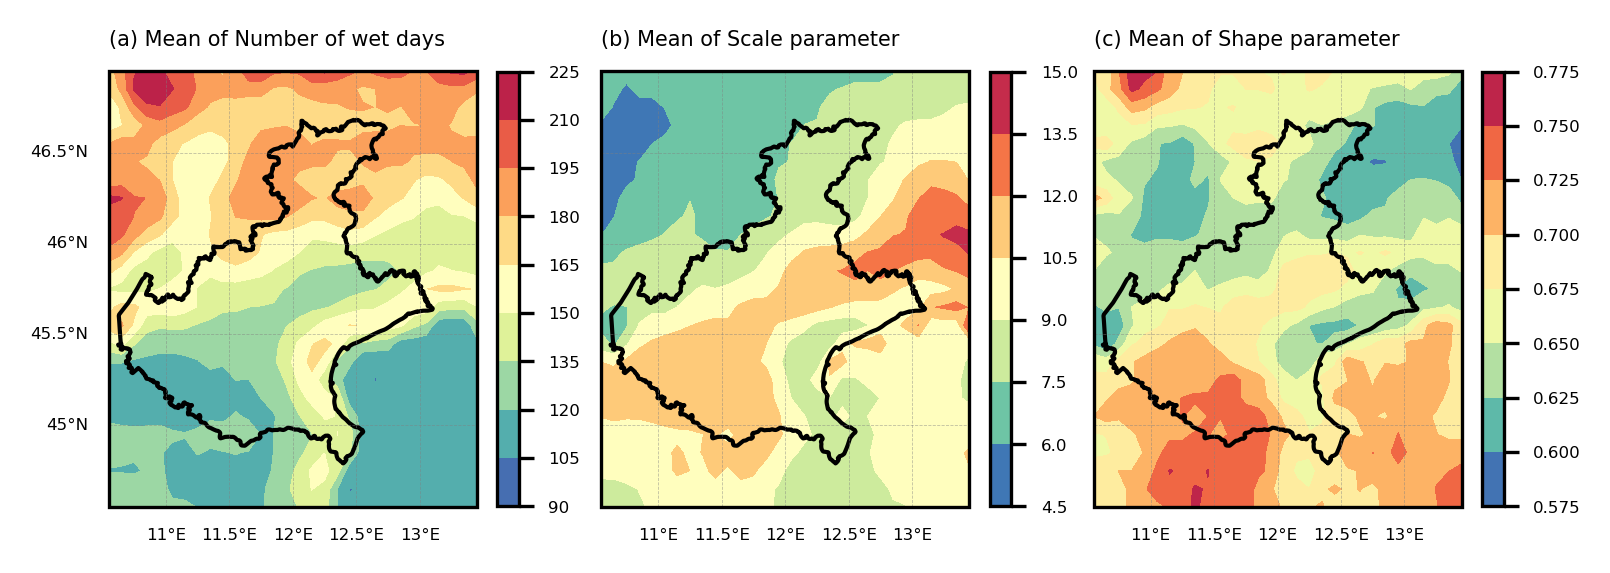

In [8]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6,3),dpi=300)
gs = gridspec.GridSpec(1,3)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)

a1 = ax1.contourf(lon2d, lat2d, np.mean(N,axis=0), cmap=cmap, transform=proj)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(a) Mean of Number of wet days', fontsize=5, loc='left')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)

a1 = ax1.contourf(lon2d, lat2d, np.mean(C,axis=0), cmap=cmap, transform=proj)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(b) Mean of Scale parameter', fontsize=5, loc='left')

# ==============================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)

a1 = ax1.contourf(lon2d, lat2d, np.mean(W,axis=0), cmap=cmap, transform=proj)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(c) Mean of Shape parameter', fontsize=5, loc='left')


## Load BETA

In [9]:
BETA_file = f'VENETO_BETA_{product}_{time_reso}_{yy_s}_{yy_e}_npix_{param['npix']}.nc'
dir_input = os.path.join(dir_base,'1_BETA',BETA_file)
print(f'Reading Beta File : {BETA_file}') 

DATA = xr.open_dataset(dir_input)

BETA = DATA['BETA'].values

del DATA

Reading Beta File : VENETO_BETA_IMERG_3h_2002_2012_npix_3.nc


## Load GAMMA

In [10]:
GAMMA_file = f'VENETO_GAMMA_{product}_{time_reso}_{yy_s}_{yy_e}.nc'
dir_input = os.path.join(dir_base,'2_GAMMA',GAMMA_file)
print(f'Reading Gamma File: {GAMMA_file}') 

DATA = xr.open_dataset(dir_input)

GAMMA = DATA['BETA'].values

del DATA

Reading Gamma File: VENETO_GAMMA_IMERG_3h_2002_2012.nc


Text(0.0, 1.0, '(b) GAMMA')

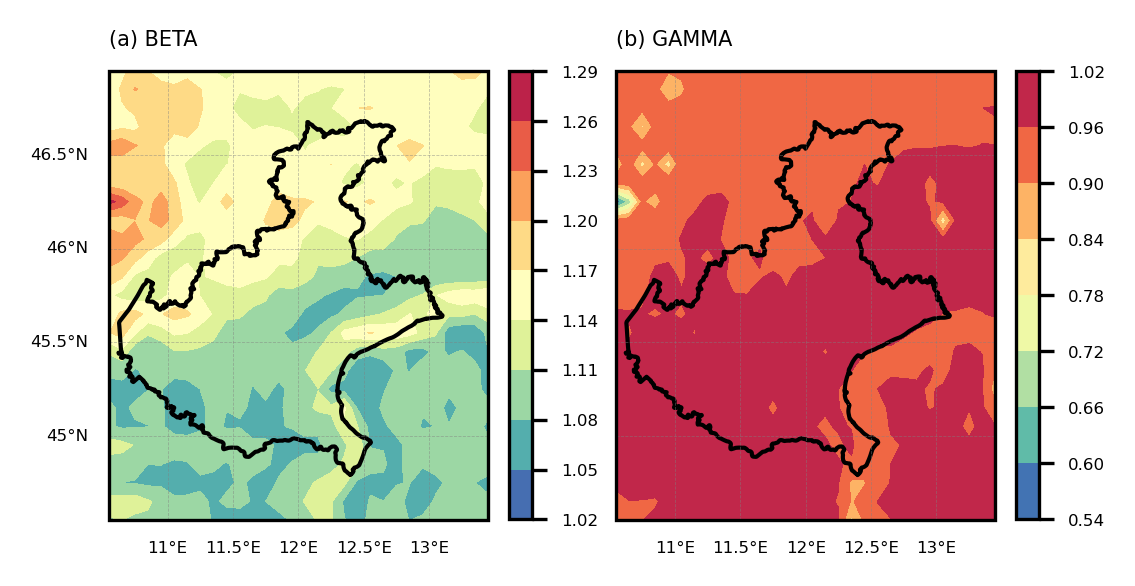

In [11]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(4,2),dpi=300)
gs = gridspec.GridSpec(1,2)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)

a1 = ax1.contourf(lon2d, lat2d, BETA, cmap=cmap)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(a) BETA', fontsize=5, loc='left')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)

a1 = ax1.contourf(lon2d, lat2d, GAMMA, cmap=cmap)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(b) GAMMA', fontsize=5, loc='left')


## Downscale parameters

In [12]:
Nd, Cd, Wd = ART_down.down_year_parameters(N, C, W, BETA, GAMMA)

Text(0.0, 1.0, '(c) Mean of Shape parameter')

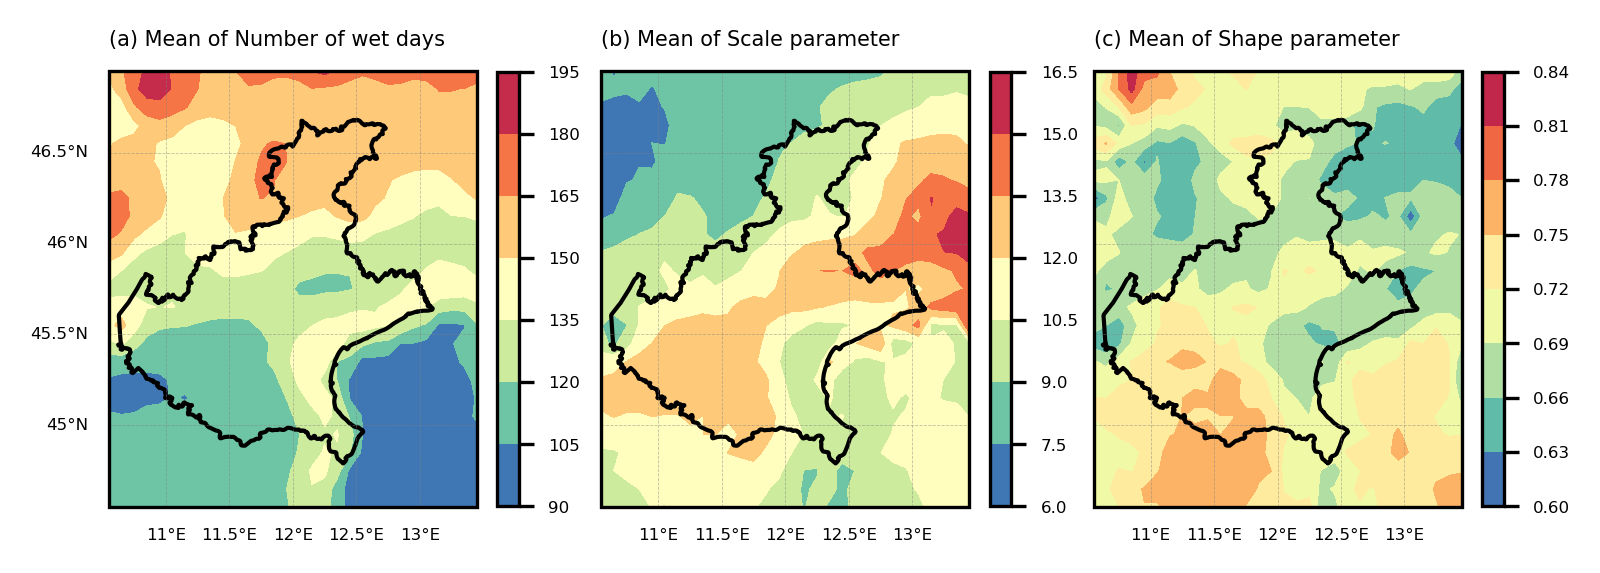

In [13]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6,3),dpi=300)
gs = gridspec.GridSpec(1,3)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)

a1 = ax1.contourf(lon2d, lat2d, np.mean(Nd,axis=0), cmap=cmap, transform=proj)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(a) Mean of Number of wet days', fontsize=5, loc='left')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)

a1 = ax1.contourf(lon2d, lat2d, np.mean(Cd,axis=0), cmap=cmap, transform=proj)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(b) Mean of Scale parameter', fontsize=5, loc='left')

# ==============================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)

a1 = ax1.contourf(lon2d, lat2d, np.mean(Wd,axis=0), cmap=cmap, transform=proj)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(c) Mean of Shape parameter', fontsize=5, loc='left')


In [14]:
Tr = [20, 50, 100]
QUANTILE = ART_down.pre_quantiles_array(Nd, Cd, Wd, Tr, lats, lons, 1)

Text(0.0, 1.0, '(c) Tr = 100 years')

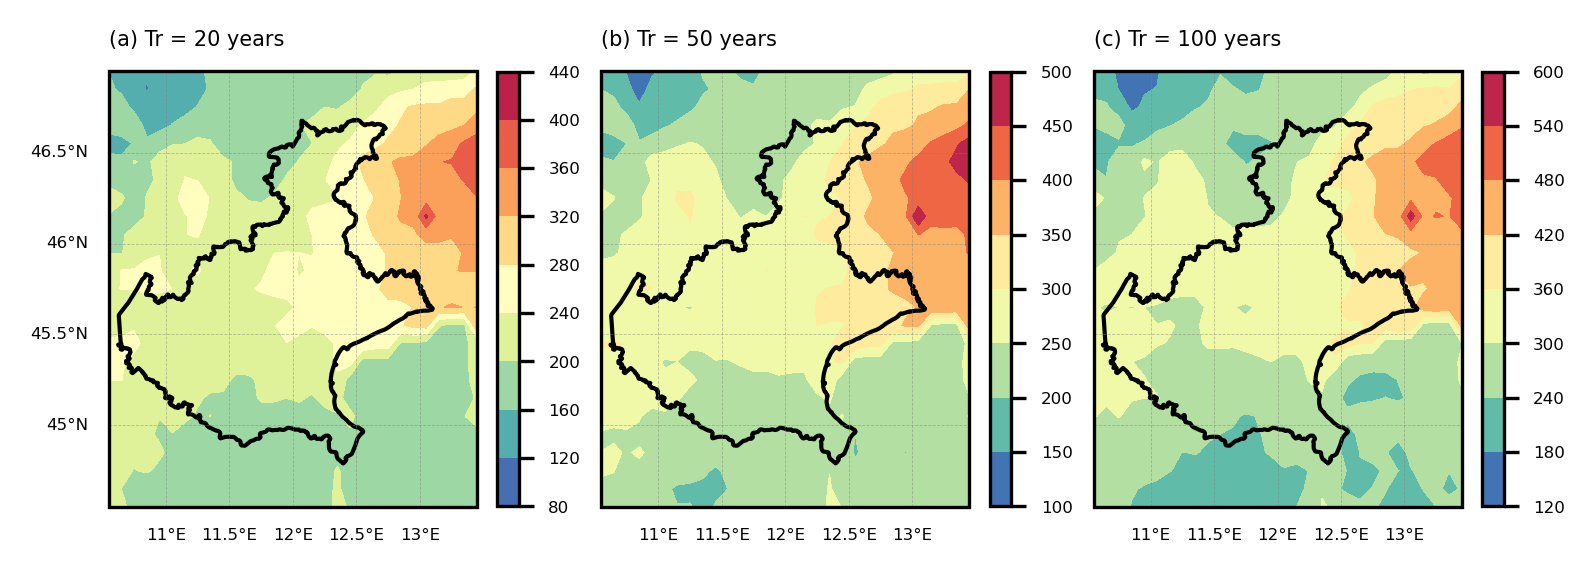

In [17]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6,3),dpi=300)
gs = gridspec.GridSpec(1,3)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)

a1 = ax1.contourf(lon2d, lat2d, QUANTILE[0,:,:], cmap=cmap, transform=proj)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(a) Tr = 20 years', fontsize=5, loc='left')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)

a1 = ax1.contourf(lon2d, lat2d, QUANTILE[1,:,:], cmap=cmap, transform=proj)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(b) Tr = 50 years', fontsize=5, loc='left')

# ==============================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)

a1 = ax1.contourf(lon2d, lat2d, QUANTILE[2,:,:], cmap=cmap, transform=proj)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(c) Tr = 100 years', fontsize=5, loc='left')
